In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
seed = 42
import multiprocessing

In [2]:
def read_file(i):
    return pd.read_csv(f'./outputs/eq/realisations_{i+1}.csv')

with multiprocessing.Pool(100) as p:
    samples = pd.concat(p.map(read_file, range(100))).reset_index(drop=True)

In [3]:
output_columns = [
    f'pos_M_{i}' for i in range(1, 102)
] + [
    f'inc_{i}' for i in range(1, 102)
] + [
    f'prop_{i}' for i in range(1, 102)
]
outputs = samples[output_columns]
features = samples.drop(output_columns, 1)
n_features = len(features.columns)
n_outputs = len(outputs.columns)

/tmp/ipykernel_74274/3800288736.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features = samples.drop(output_columns, 1)


In [4]:
features.columns

Index(['EIR', 'eta', 'Q0', 's2', 'rU', 'cD', 'g_inf', 'cU', 'kb', 'ub', 'uc',
       'ud', 'kc', 'b0', 'b1', 'IB0', 'IC0', 'tau', 'phi0', 'phi1', 'mu', 'f',
       'fd0', 'ad0', 'gd'],
      dtype='object')

In [5]:
idx_train, idx_test = train_test_split(
    np.arange(100000),#np.arange(len(outputs)),
    test_size=0.2,
    random_state=seed
)

In [6]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers

2023-01-21 07:55:00.291285: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-21 07:55:00.425001: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
output_ranges = [
    (0, 101), # prev
    (101, 202), # inc
    (202, 303) # prop
]

output_stats = [
    (
        np.mean(outputs.iloc[idx_train].to_numpy()[:,lower:upper], axis=None),
        np.std(outputs.iloc[idx_train].to_numpy()[:,lower:upper], axis=None)
    )
    for lower, upper in output_ranges
]

standardised_output = np.concatenate([
    outputs.to_numpy()[:,output_ranges[i][0]:output_ranges[i][1]] / output_stats[i][1] - output_stats[i][0]
    for i in range(len(output_ranges))
], axis=1)

In [8]:
X_train = features.iloc[idx_train]
y_train = standardised_output[idx_train]
X_test = features.iloc[idx_test]
y_test = standardised_output[idx_test]

scaler = layers.Normalization()
scaler.adapt(X_train.to_numpy())

2023-01-21 07:55:11.209748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-21 07:55:12.186896: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 36833 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:27:00.0, compute capability: 8.0
2023-01-21 07:55:12.188740: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 37815 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:28:00.0, compute capability: 8.0


In [9]:
def create_model(
    optimiser='adam',
    n_hidden=3,
    units=288,
    dropout=.1,
    loss='log_cosh',
    hidden_activation='relu',
    hidden_initialiser='he_normal',
    output_activation='linear',
    output_initialiser='glorot_normal'
):
    model = Sequential()
    model.add(layers.Input(shape=(n_features,), dtype='float32'))
    model.add(scaler)
    for i in range(n_hidden):
        model.add(layers.Dense(
            units,
            activation=hidden_activation,
            kernel_initializer=hidden_initialiser)
        )
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(n_outputs, activation=output_activation, kernel_initializer=output_initialiser))
    model.compile(loss=loss, optimizer=optimiser, metrics='mse')
    return model

In [10]:
model = create_model()
model.fit(X_train, y_train, batch_size=100, epochs=100)

Epoch 1/100
 55/800 [=>............................] - ETA: 2s - loss: 0.2148 - mse: 0.6946 

2023-01-18 15:38:12.745756: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


800/800 [==============================] - 3s 3ms/step - loss: 0.0492 - mse: 0.1358
Epoch 2/100
800/800 [==============================] - 2s 3ms/step - loss: 0.0168 - mse: 0.0395
Epoch 3/100
800/800 [==============================] - 2s 3ms/step - loss: 0.0135 - mse: 0.0312
Epoch 4/100
771/800 [===========================>..] - ETA: 0s - loss: 0.0118 - mse: 0.0270

KeyboardInterrupt: 

In [52]:
y_hat = model.predict(X_test)

625/625 [==============================] - 1s 1ms/step


In [65]:
def inverse_standardise(x):
    return np.concatenate([
        (x[:,output_ranges[i][0]:output_ranges[i][1]] + output_stats[i][0]) * output_stats[i][1]
        for i in range(len(output_ranges))
    ], axis=1)

In [72]:
def inc_0_5(y):
    return tf.reduce_sum(y[:,101:101+5], axis=1) / tf.reduce_sum(y[:,202:202+5], axis=1)

In [72]:
def inc_0_5(y):
    return tf.reduce_sum(y[:,101:101+5], axis=1) / tf.reduce_sum(y[:,202:202+5], axis=1)

Text(0, 0.5, 'true')

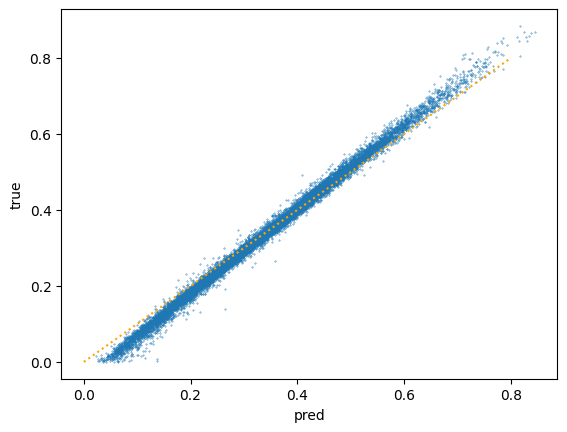

In [71]:
plt.scatter(prev_2_10(inverse_standardise(y_hat)), prev_2_10(inverse_standardise(y_test)), s=0.1)
plt.plot(np.linspace(0, 0.8), np.linspace(0, 0.8), linestyle=':', color='orange')
plt.xlabel('pred')
plt.ylabel('true')

Text(0, 0.5, 'true')

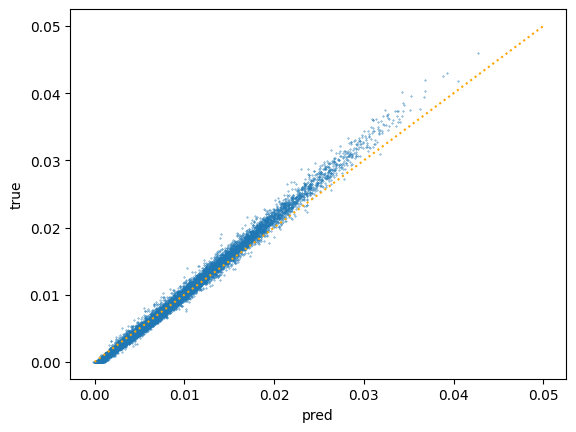

In [75]:
plt.scatter(inc_0_5(inverse_standardise(y_hat)), inc_0_5(inverse_standardise(y_test)), s=0.1)
plt.plot(np.linspace(0, 0.05), np.linspace(0, 0.05), linestyle=':', color='orange')
plt.xlabel('pred')
plt.ylabel('true')

In [ ]:
import keras_tuner as kt

In [ ]:
def bulid_hypermodel(hp):
    return create_model(
        n_hidden = hp.Int("n_hidden", min_value=1, max_value=5, step=1),
        units = hp.Int("units", min_value=32, max_value=512, step=32),
        dropout = hp.Float("dropout", min_value=0., max_value=.2, step=.01),
        loss = hp.Choice("loss", ['mse', 'log_cosh']),
        hidden_activation = hp.Choice("hidden_activation", ['relu', 'elu']),
        output_activation = hp.Choice("output_activation", ['linear', 'softmax'])
    )

In [16]:
tuner = kt.Hyperband(
    hypermodel=bulid_hypermodel,
    objective="val_mse",
    max_epochs=100,
    seed=42,
    overwrite=True,
    directory="hyperparameters",
    project_name="eq",
)

In [17]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
n_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.2, 'step': 0.01, 'sampling': None}
loss (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'log_cosh'], 'ordered': False}
hidden_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
output_activation (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'softmax'], 'ordered': False}


In [18]:
X_hyp_train, X_hyp_val, y_hyp_train, y_hyp_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=seed
)

In [19]:
tuner.search(
    X_hyp_train,
    y_hyp_train,
    validation_data=(X_hyp_val, y_hyp_val),
    callbacks=[tf.keras.callbacks.EarlyStopping("mse", min_delta=1e-10, patience=5)]
)

Trial 254 Complete [00h 01m 33s]
val_mse: 0.5066097974777222

Best val_mse So Far: 3.450794247328304e-05
Total elapsed time: 03h 35m 36s
INFO:tensorflow:Oracle triggered exit


625/625 [==============================] - 1s 1ms/step


Text(0, 0.5, 'true')

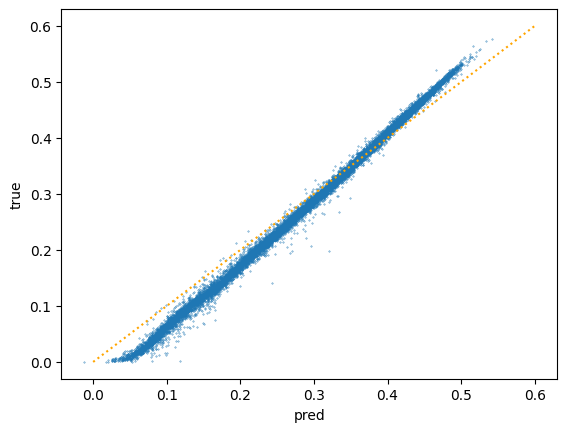

In [23]:
bm = tuner.get_best_models(num_models=1)[0]
y_hat = model.predict(X_test)
plt.scatter(y_hat.flatten(), y_test.to_numpy().flatten(), s=0.1)
plt.plot(np.linspace(0, 0.7), np.linspace(0, 0.7), linestyle=':', color='orange')
plt.xlabel('pred')
plt.ylabel('true')

In [21]:
tuner.results_summary()

Results summary
Results in hyperparameters/eq
Showing 10 best trials
Trial summary
Hyperparameters:
n_hidden: 5
units: 288
dropout: 0.0
loss: log_cosh
hidden_activation: relu
output_activation: linear
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0229
Score: 3.450794247328304e-05
Trial summary
Hyperparameters:
n_hidden: 4
units: 256
dropout: 0.01
loss: mse
hidden_activation: relu
output_activation: linear
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0142
Score: 3.650778307928704e-05
Trial summary
Hyperparameters:
n_hidden: 3
units: 64
dropout: 0.01
loss: mse
hidden_activation: relu
output_activation: linear
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0228
Score: 3.801256025326438e-05
Trial summary
Hyperparameters:
n_hidden: 4
units: 64
dropout: 0.01
loss: mse
hidden_activation: relu
output_activation: linear
tuner/epochs: 100
tuner/initial_epoch: 34
tun

In [12]:
model.save('models/eq')

INFO:tensorflow:Assets written to: models/eq/assets
